###  Planet Analytics API Tutorial

<h1 style="margin-top:10px;">Change Detection</h1>

## Overview

1. [Introduction](#1.-Introduction) 

> Introduction to Planet Change Detection Feeds

2. [Change Detection Results](#2.-Change-Detection-Results)

> Investigate change detection results data
    
3. [Visualizing Change Detections](#3.-Visualizing-Change-Detections)
    
> Explore change detection datasets visually and against Planet imagery

4. [Change Detections Tip & Cue Tasking](#4.-Change-Detections-Tip-&-Cue-Tasking)
    
> Task high resolution collects using change detections


## 1. Introduction

In the previous notebook, we took a look at accessing Planet Analytic Feeds Results for both segmentation and object detection, and showed how to visualize Analytic Feeds data with maps and Planet imagery. 

In this notebook, we take a closer look at a specific type of change: Road & Building Constructions. We'll show how to use Analytic Feeds and Subscriptions to get this type of Change Detection result, and we'll show how this data can be visualized.

## 2. Change Detection Results

Planet's Road & Building Change Detection product has been built through the following steps:

1. Develop a high performing road and building detection model and leverage it to extract roads and buildings from imagery
2. Run road and building detection over an AOI for an extended period of time, gathering as many data points as possible. From month to month, variations in atmosphere, shadows and other factors cause very small differences in the outputs over time leading to significant noise or “flicker”
3. We de-noise the results by considering the temporal context of each pixel detected. This leads to a more consistent output, however it does introduce a "lag" in when we are able to detect change
4. We then compare the most recent de-noised output with the previous de-noised output, pull out the differences and vectorize them into polygons, or more specifically into grid cells. This has the benefit of signaling where our model has detected a change.

#### How do we define building and road construction?

By buildings, we refer to any 3D man-made structure that is static and where a person could take shelter in. For example, this includes residential buildings, stadiums, warehouses and storage tanks. 

By roads, we mean any man-made path designed for cars to drive on. 

Our definition of construction is the transition of land into these man-made structures. It does not include reconstruction or modification of existing structures. For example, new stories added to a building will not be detected.

#### What does a change detection result represent?

In the building construction feed, a change result contains a geographic polygon or grid cell that represents the footprint of a contiguous area where we have detected building construction. Thus, these polygons represent general built-up area, and may not identify individual buildings. They may be a group of small buildings clumped together, or a new adjacent wing of an existing building.

In the case of the road construction feed, the change results also contain a polygon or grid cell. It represents the footprint of a contiguous area where a road segment has been constructed.

#### When did the change actually occur?

Building construction is typically detected an average of two months after the event took place, while road construction is detected an average of two and half months after the event took place. Our system performs statistical inference on the time series of images at the pixel level, and issues a change detection once there is enough confidence that a true transition occurred. Currently, we use images from Planet's Monthly Basemaps, which have a monthly sampling rate. This results in an average lag of two to two and half month lag and a monthly cadence. 

![Diagram that explains the relationship between when a building or road event happens and when it is actually detected to illustrate cadence/lag](./imgs/cadence_lag_diagram.png)

### Open this notebook in Colab below:

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analytics/user-guide/03_change_detection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Accessing Change Detection Results

Let's get started by accessing one of our Subscriptions. We'll see how we can get it's associated **Results** and we'll explore and visualize the data!

First we'll setup our API `base url` and `authentication` so we can make our `request`, just like in the previous tutorial.


In [1]:
import os
import requests

# Configure Auth and Base URL

# Planet Analytics API base URL
PAA_BASE_URL = "https://api.planet.com/analytics/"

# API Key Config
API_KEY = os.environ['PL_API_KEY']

# Alternatively, you can just set your API key directly as a string variable:
# API_KEY = "YOUR_PLANET_API_KEY_HERE"

# Setup Auth
BASIC_AUTH = (API_KEY, '')

# Create a requests session to use
session = requests.Session()

# Setup authentication on our requests session
session.auth=BASIC_AUTH

Next we'll use the `Requests` library to get a list of our available Subscriptions. 

In [2]:
# Check that everything is setup correctly
subscriptions_list_url = PAA_BASE_URL + 'subscriptions' + '?limit=1000'
resp = session.get(subscriptions_list_url)
if resp.status_code == 200:
    print('Successfully accessed Planet Analytics API')
    subscriptions = resp.json()['data']
    print('Available subscriptions:', len(subscriptions))
else:
    print('There was an error accessing the Planet Analytics API:', resp.content)

Successfully accessed Planet Analytics API
Available subscriptions: 567


We'll make a couple helper functions for "pretty printing" our responses:

In [3]:
# Pretty Print Helper
import pprint
pp = pprint.PrettyPrinter(indent=4)

# JSON Pretty Print Helper
import json

def jpp(data):
    print(json.dumps(data, indent=4))

#### Change Detection Subscription

Now let's access a Change Detection subscription by making a request to the `subscriptions` endpoint using a **subscription id**.

In [4]:
# Define the Subscripton UUID
#subscription_id = "PASTE_YOUR_SUBSCRIPTION ID HERE"

# Define the Subscripton UUID
#subscription_id = "PASTE_YOUR_SUBSCRIPTION ID HERE"

# Example subcription IDs:

# Melbourne, Australia:
# subscription_id = "2f71f34a-c9f0-4348-9c5d-278b1d7a6b02" # Monthly Road Construction
subscription_id = "234e9cb1-49f1-418a-899e-52e4edfd55d4" # Monthly Building Construction

# Mckinney City, Texas, USA:
#subscription_id = "c84d91c5-2d04-4447-a0a6-806b2a297343" # Monthly Building Construction

# Old Baldy, New Mexico, USA:
#subscription_id = "c4ed4a53-dacf-4fa3-8570-5804f67c330b"

# Construct the URL for the Subscription
subscription_url = PAA_BASE_URL + 'subscriptions/' + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscriptions list 
subscription = session.get(subscription_url).json()

# Print the subscription object
print(json.dumps(subscription, sort_keys=True, indent=4))

# Print subscription data
print("{} \n{}\nSubscription Id: {}\n".format(subscription['title'], subscription['description'], subscription['id']))


Request URL: https://api.planet.com/analytics/subscriptions/234e9cb1-49f1-418a-899e-52e4edfd55d4
{
    "created": "2020-11-05T23:16:27.076Z",
    "description": "Building Change Detection",
    "endTime": "2020-01-01T00:00:00.000Z",
    "feedID": "bc9af281-0d7a-4d2e-81b0-c68815c8dbf9",
    "geometry": {
        "coordinates": [
            [
                [
                    144.748992919922,
                    -37.6414223442131
                ],
                [
                    145.188446044922,
                    -37.6414223442131
                ],
                [
                    145.188446044922,
                    -37.3144753041441
                ],
                [
                    144.748992919922,
                    -37.3144753041441
                ],
                [
                    144.748992919922,
                    -37.6414223442131
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "234e9cb1-49f1-418a-899e

The above output should look familiar from the previous tutorials. We see the title, AOI, TOI, and other metadata about the Subscription.

Now we can move on to getting the change detection items from the **Results** collection for this Subscription:

#### Change Detection Results Items

We can use the Subscription `id` property to get the `items` from the **Results** `collection`  for this Subscription. 

Since there are multiple pages of results returned from the API, we'll follow the `next` links provided in the API response and fetch all of the results using our `get_next_link` helper function:

In [5]:
# Helper to get the "next" link
def get_next_link(links):
    for link in links:
        if link['rel'] == 'next':
            return link['href']

In [6]:
# Get the URL for the subscription's results collection items, using the 'rel' link from the subscription object
subscription_items_url = list(filter(lambda link: link['rel'] == 'results', subscription['links']))[0]['href']

print("Subscription Items URL:\n{}\n".format(subscription_items_url))

# Get subscription results items (Change Detections)
subscription_items = session.get(subscription_items_url).json()

# First next link
next_link =  get_next_link(subscription_items['links'])

# Loop to get all pages of features
while next_link:
    
    print('Getting page: {}'.format(next_link))
    
    # Use "next" link to request next page
    next_collection = session.get(next_link).json()
    
    # Add features from new page to our original list of features
    subscription_items['features'].extend(next_collection['features'])
            
    # Get the next "next" link
    next_link = get_next_link(next_collection["links"])

Subscription Items URL:
https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items

Getting page: https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items?before=c94d0230-2f5b-44ca-a7cc-71d4e07a1885
Getting page: https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items?before=d2962646-56bb-43b8-95a2-72ef41ae4a96
Getting page: https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items?before=b196ff18-42c9-47f1-9fe7-29a066baecf2
Getting page: https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items?before=0a41ca81-6264-4282-8255-2a2d71a02c83
Getting page: https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items?before=4b8cd22f-73e6-4a13-aa51-a10445e77e12


In [7]:
# Inspect our subscription items GeoJSON FeatureCollection

print('Total Change Detection Items: {}'.format(len(subscription_items['features'])))

subscription_items

Total Change Detection Items: 1405


{'features': [{'created': '2020-11-06T01:45:34.632Z',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[145.093002299243, -37.6368005836103],
      [145.093002299243, -37.6373443345408],
      [145.093345621996, -37.6373443345408],
      [145.093345621996, -37.6370724595729],
      [145.093646029406, -37.6370724595729],
      [145.093688944748, -37.6370724595729],
      [145.093688944748, -37.6368005836103],
      [145.093002299243, -37.6368005836103]]]},
   'id': 'bd680227-b242-4da2-b6ce-745f87cf1621',
   'links': [{'href': 'https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items/bd680227-b242-4da2-b6ce-745f87cf1621',
     'rel': 'self',
     'type': 'application/geo+json'},
    {'href': 'https://api.planet.com/analytics/collections/234e9cb1-49f1-418a-899e-52e4edfd55d4/items/bd680227-b242-4da2-b6ce-745f87cf1621/resources/source-quad',
     'rel': 'source-quad',
     'type': 'image/tiff'},
    {'href': 'https://tiles.planet.com/basemaps/v1/planet-

### Working with Change Detection Results

Now that we've got our Change Detection items, let's use use GeoPandas to explore our data:

In [8]:
import geopandas as gpd
import pandas as pd

# Make a GeoPandas data frame from our collection items
items_gdf = gpd.GeoDataFrame.from_features(subscription_items['features'])

# Show the first five results from our GeoDataFrame
items_gdf.head()

,geometry,date_after,date_before,object_area_m2,observed,source_mosaic_after,source_mosaic_before,source_mosaic_name,source_quad_id
0,"POLYGON ((145.09300 -37.63680, 145.09300 -37.6...",2019-12-01T00:00:00Z,2019-10-01T00:00:00Z,343.379105,2019-12-01T00:00:00Z,global_monthly_2019_12_mosaic,global_monthly_2019_10_mosaic,global_monthly_2019_12_mosaic,1849-792
1,"POLYGON ((145.07996 -37.63517, 145.07996 -37.6...",2019-12-01T00:00:00Z,2019-10-01T00:00:00Z,1445.053735,2019-12-01T00:00:00Z,global_monthly_2019_12_mosaic,global_monthly_2019_10_mosaic,global_monthly_2019_12_mosaic,1849-792
2,"POLYGON ((145.14004 -37.63191, 145.14004 -37.6...",2019-12-01T00:00:00Z,2019-10-01T00:00:00Z,958.600002,2019-12-01T00:00:00Z,global_monthly_2019_12_mosaic,global_monthly_2019_10_mosaic,global_monthly_2019_12_mosaic,1849-792
3,"POLYGON ((145.08099 -37.62810, 145.08099 -37.6...",2019-12-01T00:00:00Z,2019-10-01T00:00:00Z,743.988061,2019-12-01T00:00:00Z,global_monthly_2019_12_mosaic,global_monthly_2019_10_mosaic,global_monthly_2019_12_mosaic,1849-792
4,"POLYGON ((145.13386 -37.62076, 145.13386 -37.6...",2019-12-01T00:00:00Z,2019-10-01T00:00:00Z,286.149254,2019-12-01T00:00:00Z,global_monthly_2019_12_mosaic,global_monthly_2019_10_mosaic,global_monthly_2019_12_mosaic,1849-792


### Result Item Properties

Let's take a look at the rest of the columns available to us:

In [9]:
# List the item properties (columns)
for column in items_gdf.columns.values:
    print(column)

geometry
date_after
date_before
object_area_m2
observed
source_mosaic_after
source_mosaic_before
source_mosaic_name
source_quad_id


##### Source Properties
The `source_` properties all relate to the source satellite imagery that the detections were made against. The `source_quad_id` is the [Planet Basemaps Quad](https://developers.planet.com/docs/basemaps/) file identifier of the original source imagery file.

##### Detection Object Properties
The `object_` properties describe some meta-data about each detection, like the area (for polygons). 

Also relevant are the `geometry` (the "footprint" of the detection) and `observed`. 

The properties of each change detection result include dates that confidently delimit the possible time range of the event.  `date_after` is when change is detected, and `date_before` represents an estimation of the latest month before change took place.  

## 3. Visualizing Change Detections

In this section, we'll take a look at our Change Detection **Results** with interactive visualizations using [PyViz tools](https://pyviz.org). We'll create the following visualizations to explore the change detection dataset:

* Change Detections Overview
* Monthly Change Detections
* Monthly Change Detection Heatmap
* Individual Change Detection

### Change Detections Overview

Our first visualization will plot all of the change detections for the loaded subscription.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
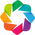

In [10]:
# Import visualization dependencies
import holoviews as hv
import geoviews as gv
from geoviews import tile_sources as gvts
import shapely
from shapely.geometry import shape, Polygon

gv.extension('bokeh')

First let's make a plot for the basemap and the subscription area of interest (AOI):

In [11]:
# Create a basemap element
basemap = gv.tile_sources.CartoLight().options(responsive=True, height=400, active_tools=['pan', 'wheel_zoom'])

# Create a subscription aoi plot using the susbscription geometry
subscription_aoi_plot = gv.Shape(shape(subscription['geometry']), label='Subscription AOI').options(fill_alpha=0, line_color='blue', show_legend=True, padding=0.1)

Next we can plot all of the change detection items on a map, and color each by the month it was detected on:

In [ ]:
# Create the change detection items plot

# Handle Polygons vs LineStrings
if type(items_gdf.iloc[0].geometry) == Polygon:
    all_change_detections_plot = gv.Polygons(items_gdf, vdims='observed', group="Change Detections").options(color='observed', cmap='Spectral', show_legend=True)
else:
    all_change_detections_plot = gv.Path(items_gdf, vdims='observed', group="Change Detections").options(color='observed', cmap='Spectral', show_legend=True)

basemap * subscription_aoi_plot * all_change_detections_plot

### Monthly Change Detections

In order to visualize monthly change detection, we'll need to define the date range over which our detections take place. Let's also convert the columns representing dates `observed`, `date_before`, and `date_after` to `datetime` objects. 

In [ ]:
# Convert date columns into a datetime datatype
items_gdf["observed"] = pd.to_datetime(items_gdf["observed"], utc=True)
items_gdf["date_before"] = pd.to_datetime(items_gdf["date_before"], utc=True)
items_gdf["date_after"] = pd.to_datetime(items_gdf["date_after"], utc=True)

In [ ]:
# Get the first and last observed dates
first_observed = items_gdf['observed'].min()
last_observed = items_gdf['observed'].max()

# Create a date range
date_range = pd.date_range(start=first_observed, end=last_observed, freq='MS')
date_range

In order to show our Planet imagery, we'll create a helper function to create basemap tile server URLs from mosaic names. We'll be using the `source_mosaic_after` property from our change detection items to set our basemap.

In [ ]:
def get_mosaic_url(mosaic_name):
    return 'https://tiles.planet.com/basemaps/v1/planet-tiles/'+mosaic_name+'/gmap/{Z}/{X}/{Y}.png?api_key='+ API_KEY

We'll also create a control to show/hide the imagery layer using a [Panel](https://panel.holoviz.org/) widget: 

In [ ]:
import panel as pn
pn.extension()

show_imagery_widget = pn.widgets.Checkbox(name='Show Imagery')

Finally let's use a Holoviews DynamicMap to create our visualization:

In [ ]:
# Define the dynamic map callback function that takes an observed time, 
# and an argument to show the basemap using the @pn.depends decorater.

@pn.depends(show_imagery=show_imagery_widget)
def render_items_for_month(observed, show_imagery):
    # Ensure observed datetime is in the proper format
    observed = pd.to_datetime(observed, utc=True)
    
    # Select only the items with selected observed date
    month_items = items_gdf.loc[items_gdf['observed'] == observed]
    
    # Create a geoviews polygons element to plot change detection items
    if type(items_gdf.iloc[0].geometry) == Polygon:
        items_plot = gv.Polygons(month_items, label='Change Detections').options(fill_color='red', line_width=0, show_legend=True)
    else:
        items_plot = gv.Path(month_items, label='Change Detections').options(line_color='red', show_legend=True)

    # Show corresponding Planet basemaps imagery using a WMTS element
    current_mosaic = month_items.iloc[0]['source_mosaic_after']
    mosaic_url = get_mosaic_url(current_mosaic)
    imagery_plot = gv.WMTS(mosaic_url).options(alpha=1 if show_imagery else 0)
        
    return imagery_plot * items_plot
    
# Use a dynamic map to show items
# Here we set the range for our observed values from the date range we created above
items_plot = hv.DynamicMap(render_items_for_month, kdims=[('observed', 'Date')]).redim.values(observed=date_range)

# Output the combined plots using a panel layout
pn.Column(
    pn.Row(basemap * subscription_aoi_plot * items_plot, ),
    pn.Row(show_imagery_widget),
    sizing_mode='stretch_width'
)

### Monthly Change Detections Heatmap

Let's aggregate our change detection points into a heatmap that will give us some insight into where the most change is happening for each month. 

We'll use the same approach as we did with the monthly change detection by using a `DynamicMap` to plot different data for different months, but this time we'll use a Geoviews `HexTiles` element to plot a heatmap instead of polygons for items. We'll also add a control for changing the bin size (the area over which to aggregate detections) for the heatmap.

In [ ]:
# Create a widget to control bin size
# NOTE: Change date to see bin size recalculated
bin_size_widget = pn.widgets.IntSlider(name='Bin Size', start=5, end=15, step=1, value=5)

# Create a widget to toggle showing detection items
show_items_widget = pn.widgets.Checkbox(name='Show Items')

# Define the dynamic map callback function that takes an observed time, 
# and an argument to show the basemap using the @pn.depends decorater.
@pn.depends(show_imagery=show_imagery_widget, bin_size=bin_size_widget, show_items=show_items_widget)
def render_items_for_month(observed, show_imagery, bin_size, show_items):
    # Ensure observed datetime is in the proper format
    observed = pd.to_datetime(observed, utc=True)
    
    # Select only the items with selected observed date
    month_items = items_gdf.loc[items_gdf['observed'] == observed]
    
    # The heatmap rendering requires 2 or more distinct geometries. If there is only one,
    # let's duplicate it and offset the new geometry by a small amount
    if len(month_items) == 1:
        geom = month_items.iloc[0]['geometry']
        new_geom = shapely.affinity.translate(geom, xoff=0.01)
        duplicate_row = month_items.copy()
        duplicate_row['geometry'] = new_geom
        # Add row with new geometry
        month_items = month_items.append(duplicate_row)
    
    # Use centroids to cacluclate heatmap
    centroid_month_items = month_items.copy()
    centroid_month_items['geometry'] = centroid_month_items['geometry'].centroid
    
    # Create a geoviews HexTiles element to plot change detection item counts  
    items_heatmap = gv.HexTiles(centroid_month_items, label='Detection Count').options(
        gridsize=bin_size,
        fill_alpha=0.5 if show_imagery else 1,
        cmap='YlOrRd', colorbar=True, colorbar_position='bottom', show_legend=True, tools=['hover']
    )
    
    # Create a geoviews polygons element to plot change detection items
    if type(items_gdf.iloc[0].geometry) == Polygon:
        items_plot = gv.Polygons(month_items, label='Change Detections').options(
            line_alpha=1 if show_items else 0, 
            line_width=2, line_color='black', fill_alpha=0, show_legend=True
        )
    else:
        items_plot = gv.Path(month_items, label='Change Detections').options(
            line_alpha=1 if show_items else 0, 
            line_width=2, line_color='black', show_legend=True
        )
        
    
    # Show corresponding Planet basemaps imagery using a WMTS element
    current_mosaic = month_items.iloc[0]['source_mosaic_after']
    mosaic_url = get_mosaic_url(current_mosaic)
    imagery_plot = gv.WMTS(mosaic_url).options(alpha=1 if show_imagery else 0)
        
    return imagery_plot * items_heatmap * items_plot
    
# Use a dynamic map to show items
# Here we set the range for our observed values from the date range we created above
heatmap_plot = hv.DynamicMap(render_items_for_month, kdims=[('observed', 'Date')]).redim.values(observed=date_range)

# Combine the plots into an overlay
combined_plots = (basemap * subscription_aoi_plot * heatmap_plot)

# Output the combined plots using a panel layout
pn.Column(
    pn.Row(combined_plots),
    pn.Row(show_imagery_widget, show_items_widget, bin_size_widget),
    sizing_mode='stretch_width'
)

### Inspecting a single change detection item
Let's use our GeoPandas GeoDataFrame to look at a single detection. We are selecting a single detection using it's index from the list of subscriptions. To look at a different subscription, we can simply change the index number at `items_gdf.iloc[N]`

In [ ]:
# Select the first detection by index
single_detection = items_gdf.iloc[10]
single_detection

Now let's visualize the detection and compare the ground truth imagery for the `observed` date and the `before_date` to see the change on the ground. 

As we saw above, the change detection item includes the names of the Planet basemaps against which the detection was made: `source_mosaic_after`, `source_mosaic_before`. 

We'll create a plot to compare this imagery and see the change that was detected!

In [ ]:
# Create a plot for the detection
detection_plot = gv.Shape(shape(single_detection['geometry'])).options(padding=3, fill_alpha=0, line_color='red', active_tools=['pan', 'wheel_zoom'])

# Format dates
before_date = single_detection['date_before'].strftime('%B, %Y')
observed_date = single_detection['observed'].strftime('%B, %Y')

# Create plots for the imagery
before_imagery_plot = gv.WMTS(get_mosaic_url(single_detection['source_mosaic_before'])).options(title=before_date, width=400, height=400)
observed_imagery_plot = gv.WMTS(get_mosaic_url(single_detection['source_mosaic_after'])).options(title=observed_date, width=400, height=400)

# Show the combined plots
detection_plot * (before_imagery_plot + observed_imagery_plot)


## 4. Change Detections Tip & Cue Tasking

3-5 m resolution and global daily coverage is perfectly fit to scan country-wide areas to find areas that have experienced **road development** and/or **building construction**. This provides a signal of **where to allocate 50 cm resolution assets** which can then be used to derive **routable road networks** and **building footprints** and integrate them into your workflows.

Planet has satellite constellations capable of **doing both**.

Throughout this notebook we’ve learned how to use **the Roads & Building Construction API** to find, assure quality of and visualize meaningful changes from the petabytes of data from PlanetScope, imagery derived from **our first constellation**.

![TipAndCue.png](imgs/TipAndCue.png)

As of today, these two constellations operate independently - once the GeoJSON geometries from the Change Detection results has been manually extracted, it is possible to use our Tasking API or our Tasking Dashboard to task a SkySat and get a higher-resolution image. It is then possible to run Computer Vision models on SkySat Imagery to extract building footprints and road networks.


For more information on how to task SkySats using the API, check out:
* [Tasking API User Guide](https://developers.planet.com/docs/tasking/)
* [Tasking API Reference Information](https://developers.planet.com/docs/tasking/reference/)

If you’re interested in trying out SkySat tasking, please contact your Sales Representative.

For any additional information or feedback on Change detection, please contact  [Justin Davis](justin@planet.com) and/or [Jonathan Evens](jonathan.evens@planet.com)

*Note: Tasking provides programmatic capabilities (API and GUI implementations) to automatically task satellites that will produce various types of satellite imagery for a certain period of time that is also defined by the end-to-end user.*